# Introduction
Scope of the notebook:
- Get OSM data
- Calculate way polygon centroids as POI
- Plot POIs on Folium map
- Load administrative boundaries from Stats NZ
- Aggregate POIs within an administrative boundary

In [35]:
# Import some packages
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas 
from shapely.geometry import Point, Polygon

# User modules
import utils.data_processing as dp

# Some configs
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
#%matplotlib inline

# Get OSM data

In [2]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

In [9]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ["commercial", "office", "retail", "industrial"]
objects = ['way'] # like way, node, relation
entity = 'building'
osm_objects = [entity] + tags + objects

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entity)
# Get Data
osmdf = dp.get_osm_data(compactOverpassQLstring, osm_bbox, osm_objects)

# Calculate polygon centroids

In [10]:
osmdf_ways = osmdf.query('type == "way"')[['id', 'nodes', 'type']]
osmdf_nodes = osmdf.query('type == "node"')[['id', 'lat', 'lon']]
osmdf_ways.head()

,id,nodes,type
0,26513709,"[290588589, 5691959907, 5692007021, 5691962559...",way
1,38138779,"[448871857, 448871858, 448871859, 448871860, 5...",way
2,38139157,"[2640326061, 4301827633, 4301827634, 430182763...",way
3,48029394,"[610689114, 610689115, 610689116, 610689117, 4...",way
4,62197398,"[775852110, 775852111, 775852113, 775852115, 7...",way


In [11]:
osmdf_clean = dp.extend_ways_to_node_view(osmdf)
osmdf_centroids = osmdf_clean.groupby('way_id').agg({'lat': 'mean', 'lon': 'mean' }).reset_index()

# Plot centroids

In [13]:
map_bldgs = folium.Map(location=[-41.29, 174.8], zoom_start = 11)
    
for each in osmdf_centroids.iterrows():
    folium.CircleMarker(location = [each[1]['lat'],each[1]['lon']], radius=3, 
                        color='grey', fill=True).add_to(map_bldgs)

map_bldgs

# Get Administrative boundaries

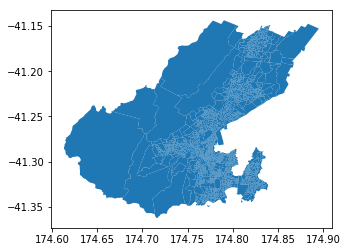

In [14]:
# Load ESRI GDB boundary files at two levels: area units; meshblock
nz_mesh = geopandas.read_file('../wellington-commutes/data/meshblock-2013/meshblock-2013.gdb/')
nz_area_unit = geopandas.read_file('../wellington-commutes/data/area-unit-2013/area-unit-2013.gdb/')

# Filter meshblocks by Wellington City TA
wlg_mesh = nz_mesh.query('TLAName == "Wellington City"')
wlg_mesh.plot()

# Filter and dissolve spatial boundaries

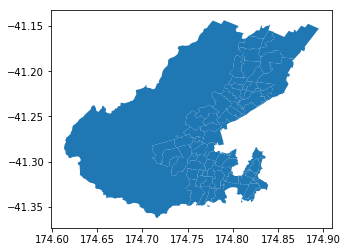

In [15]:
nz_area_unit.columns = ['AreaUnitCode', 'AU2013_V1_00_NAME','AREA_SQ_KM',
                        'LAND_AREA_SQ_KM','Shape_Length','geometry']
wlg_codes = wlg_mesh[['AreaUnitCode']]
wlg_area_units = nz_area_unit[nz_area_unit['AreaUnitCode'].isin(wlg_codes['AreaUnitCode'])]
wlg_area_units.plot()

# Aggregating POIs within spatial boundary

In [16]:
# sp_osmdf_centroids = geopandas.GeoDataFrame(osmdf_centroids, crs=nz_area_unit.crs)
sp_osmdf_centroids =  dp.coords_df_to_geopandas_points(osmdf_centroids)

In [17]:
bldgs_wgtn = geopandas.sjoin(wlg_area_units, sp_osmdf_centroids, how='inner', op='intersects')

In [18]:
(bldgs_wgtn
 .groupby('AU2013_V1_00_NAME')
 .agg({'way_id': 'count'})
 .reset_index()
 .sort_values('way_id', ascending=False)
 .head(10))

,AU2013_V1_00_NAME,way_id
14,Lambton,96
26,Willis Street-Cambridge Terrace,86
25,Thorndon-Tinakori Road,51
12,Kelburn,11
6,Island Bay East,9
21,Mt Victoria West,9
0,Adelaide,4
3,Crofton Downs,4
24,Tawa Central,3
22,Newtown West,3


# Aggregating areas

In [20]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ["residential"]
objects = ['way'] # like way, node, relation
entity = 'landuse'
osm_objects = [entity] + tags + objects 

# Generate the query string
compactOverpassQLstring = dp.generate_overpass_query(tags, objects, osm_bbox, entity)
# Get Data
osmdf = dp.get_osm_data(compactOverpassQLstring, osm_bbox, osm_objects)

In [68]:
osmdf_clean = dp.extend_ways_to_node_view(osmdf)
points_osmdf_clean = dp.coords_df_to_geopandas_points(osmdf_clean)
poly_osmdf_clean = dp.geopandas_points_to_poly(points_osmdf_clean)

In [125]:
residential_wgtn = geopandas.sjoin(wlg_area_units, poly_osmdf_clean, how='inner', op='intersects')
residential_wgtn_proj = residential_wgtn.to_crs(epsg=2193)

# residential_wgtn_proj = residential_wgtn_proj.dissolve(by='AU2013_V1_00_NAME', aggfunc='sum')
# residential_wgtn_proj['residential_area'] = residential_wgtn_proj['geometry'].area

In [110]:
area_by_stat_unit = (residential_wgtn_proj
                     .groupby('AU2013_V1_00_NAME')
                     .agg({'residential_area': 'sum'})
                     .reset_index())

area_by_stat_unit['residential_area'] = area_by_stat_unit['residential_area'] /10**6

area_by_stat_unit.head()

,AU2013_V1_00_NAME,residential_area
0,Adelaide,1.651646
1,Aro Street-Nairn Street,15.023194
2,Awarua,52.989566
3,Berhampore East,1.962512
4,Berhampore West,25.121632


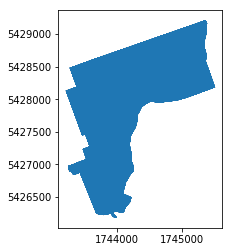

In [126]:
residential_wgtn_proj.query('AU2013_V1_00_NAME == "Karori Park"').plot()

In [133]:
import itertools
geoms = residential_wgtn_proj.query('AU2013_V1_00_NAME == "Awarua"')['geometry'].tolist()
intersection_iter = geopandas.GeoDataFrame(geopandas.GeoSeries([poly[0].intersection(poly[1]) 
                                                                for poly in  
                                                                itertools.combinations(geoms, 2) 
                                                                if poly[0].intersects(poly[1])]), columns=['geometry'])


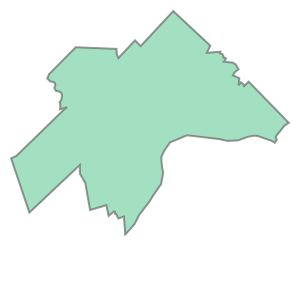

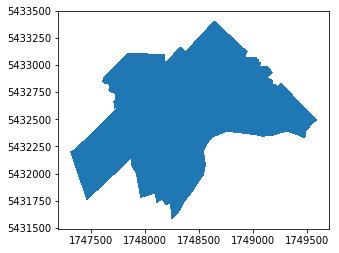

In [137]:
intersection_iter.plot()
union_iter = intersection_iter.unary_union
union_iter

In [154]:
awarua = residential_wgtn_proj.query('AU2013_V1_00_NAME == "Awarua"')
adelaide = residential_wgtn_proj.query('AU2013_V1_00_NAME == "Adelaide"')

In [143]:
sum(awarua['geometry'].area) / 10**6

52.98956643395226

In [151]:
type(awarua['geometry'])

geopandas.geoseries.GeoSeries

In [156]:
awarua.geometry.name

'geometry'